In [21]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensuring NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stoffregen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/stoffregen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/stoffregen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stoffregen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/stoffregen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/stoffregen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
data = json.loads(open("../data/processed/Oppositional_thinking_analysis_dataset.json").read())

# Compare the total number of conspiracy and critical comments

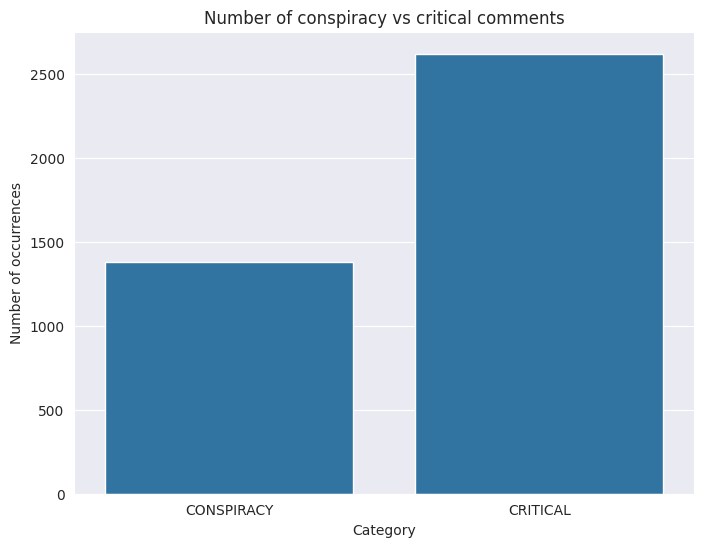

In [5]:
CONSPIRACY_counter = 0
CRITICAL_counter = 0

for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_counter+=1
    else:
        CRITICAL_counter+=1

categories = ['CONSPIRACY', 'CRITICAL']
comment_counts = pd.DataFrame({'Category': categories, 'Occurrences': [CONSPIRACY_counter, CRITICAL_counter]})

# Create the bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Occurrences', data=comment_counts)
plt.xlabel('Category')
plt.ylabel('Number of occurrences')
plt.title('Number of conspiracy vs critical comments')
# save to reports/figures
plt.savefig("../reports/figures/01/conspiracy_vs_critical.png")
plt.show()

# Compare the length of conspiracy and critical comments (in intervals)

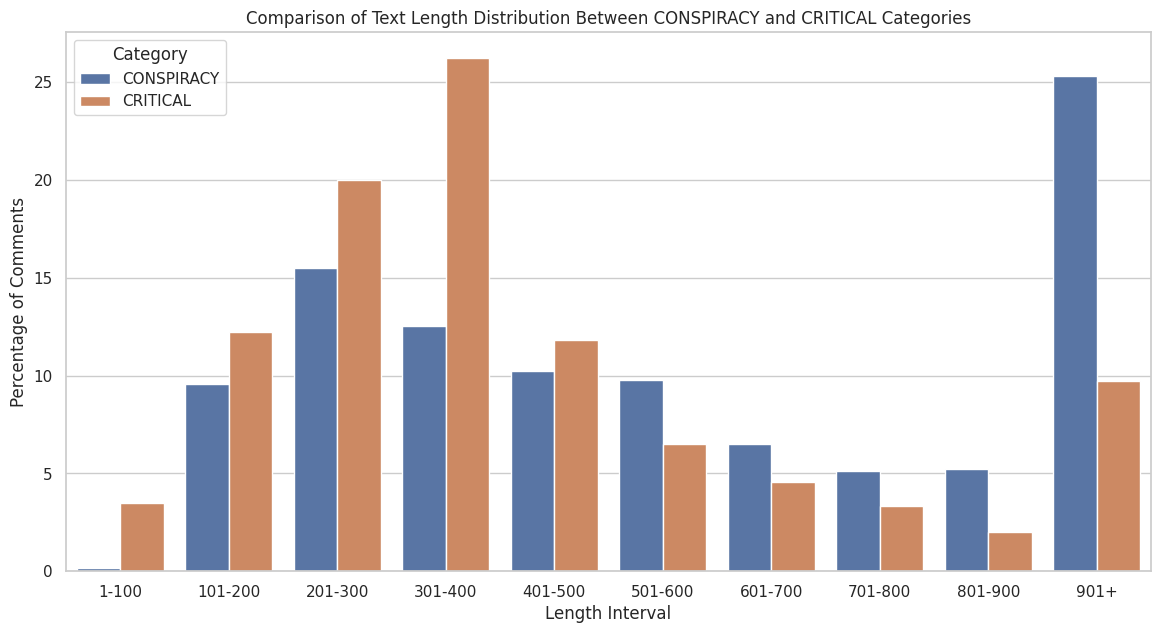

In [14]:
# Function to categorize the length into intervals
def categorize_length(length):
    if length <= 100:
        return '1-100'
    elif length <= 200:
        return '101-200'
    elif length <= 300:
        return '201-300'
    elif length <= 400:
        return '301-400'
    elif length <= 500:
        return '401-500'
    elif length <= 600:
        return '501-600'
    elif length <= 700:
        return '601-700'  # Adjusted interval correction
    elif length <= 800:
        return '701-800'
    elif length <= 900:
        return '801-900'
    else:
        return '901+'  # Adjusted to correctly include all longer comments

CONSPIRACY = []
CRITICAL = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY.append(len(comment["text"]))
    else:
        CRITICAL.append(len(comment["text"]))

# Count occurrences in specified intervals
occurrences_CONSPIRACY = Counter([categorize_length(length) for length in CONSPIRACY])
occurrences_CRITICAL = Counter([categorize_length(length) for length in CRITICAL])

# Data preparation for plotting
results = []
categories = ['CONSPIRACY', 'CRITICAL']
for category, occurrences in zip(categories, [occurrences_CONSPIRACY, occurrences_CRITICAL]):
    total = sum(occurrences.values())
    for length_interval, count in occurrences.items():
        results.append({
            'Category': category,
            'Interval': length_interval,
            'Percentage': (count / total) * 100
        })

df = pd.DataFrame(results)
# order df by "Interval" in alphabetical order
df = df.sort_values(by='Interval')

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.barplot(x='Interval', y='Percentage', hue='Category', data=df)

plt.title('Comparison of Text Length Distribution Between CONSPIRACY and CRITICAL Categories')
plt.xlabel('Length Interval')
plt.ylabel('Percentage of Comments')
plt.legend(title='Category')
# save to reports/figures
plt.savefig("../reports/figures/01/length_distribution.png")
plt.show()

# Compare the vocabulary richness in terms of lemmatized unique words between conspiracy and critical comments

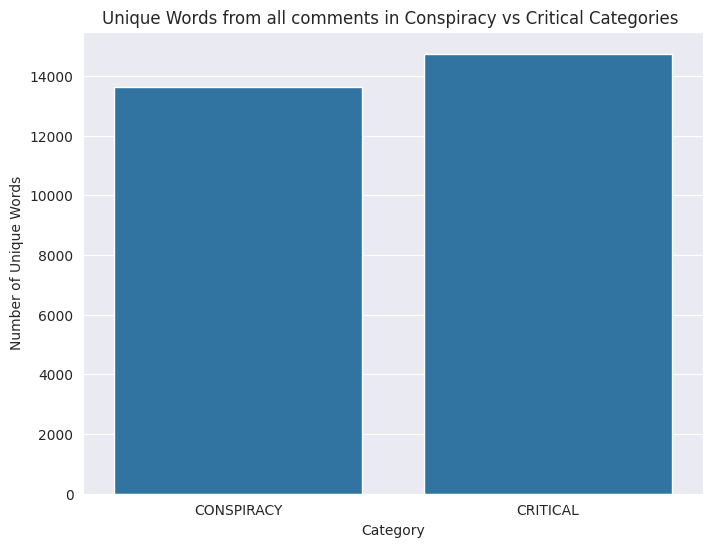

In [9]:
def get_vocabulary_richness(text:str) -> int:
    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return (lemmatized_tokens)


CONSPIRACY = []
CRITICAL = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY = CONSPIRACY + get_vocabulary_richness(comment["text"])
    else:
        CRITICAL = CRITICAL + get_vocabulary_richness(comment["text"])
unique_words_CONSPIRACY = set(CONSPIRACY) 
unique_words_CRITICAL = set(CRITICAL) 

df = pd.DataFrame({
    'Category': ['CONSPIRACY', 'CRITICAL'],
    'Unique Words': [len(unique_words_CONSPIRACY), len(unique_words_CRITICAL)]
})

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Unique Words', data=df)
plt.xlabel('Category')
plt.ylabel('Number of Unique Words')
plt.title('Unique Words from all comments in Conspiracy vs Critical Categories ')
# save fig
plt.savefig("../reports/figures/01/unique_words.png")
plt.show()

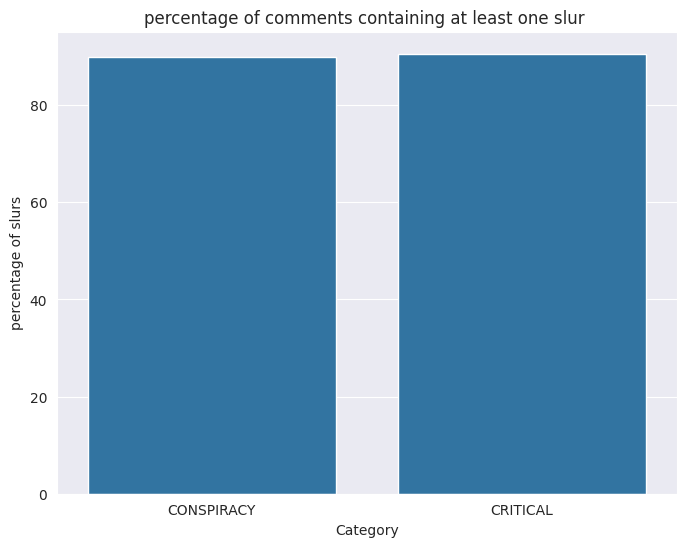

In [10]:
bad_words = json.loads(open("bad_words.json").read())
CONSPIRACY_bad_word_counter = 0
CRITICAL_bad_word_counter = 0
CONSPIRACY = []
CRITICAL = []

for comment in data:
    found_bad_word = False  
    for bad_word in bad_words:
        if bad_word in comment["text"]:
            if not found_bad_word: 
                found_bad_word = True  
                if comment["category"] == "CONSPIRACY":
                    CONSPIRACY_bad_word_counter += 1 
                else:
                    CRITICAL_bad_word_counter += 1  
            if comment["category"] == "CONSPIRACY":
                CONSPIRACY.append(bad_word)
            else:
                CRITICAL.append(bad_word)

categories = ['CONSPIRACY', 'CRITICAL']
slur_counts = [100* CONSPIRACY_bad_word_counter/CONSPIRACY_counter, 100*CRITICAL_bad_word_counter/CRITICAL_counter]

df = pd.DataFrame({
    'Category': categories,
    'Percentage of Slurs': slur_counts
})
# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Percentage of Slurs', data=df)
plt.xlabel('Category')
plt.ylabel('percentage of slurs')
plt.title('percentage of comments containing at least one slur ')
# save fig
plt.savefig("../reports/figures/01/slurs.png")
plt.show()

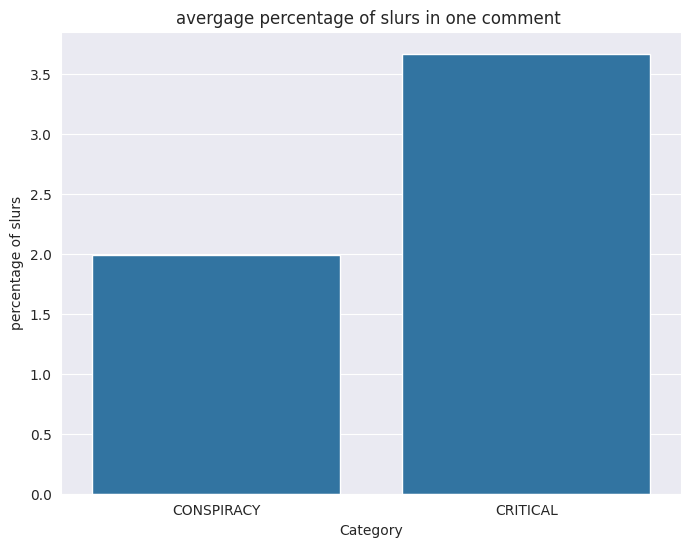

In [12]:
CONSPIRACY_avereage_bad_word_proportion_per_comment = []
CRITICAL_avereage_bad_word_proportion_per_comment = []


for comment in data:
    CONSPIRACY_badwords_per_comment = []
    CRITICAL_badwords_per_comment = []
    for bad_word in bad_words:
        if bad_word in comment["text"]:
            if comment["category"] == "CONSPIRACY":
                CONSPIRACY_badwords_per_comment.append(bad_word)
            else:
                CRITICAL_badwords_per_comment.append(bad_word)
    CONSPIRACY_avereage_bad_word_proportion_per_comment.append(len(CONSPIRACY_badwords_per_comment)/len(get_vocabulary_richness(comment["text"])))
    CRITICAL_avereage_bad_word_proportion_per_comment.append(len(CRITICAL_badwords_per_comment)/len(get_vocabulary_richness(comment["text"])))

categories = ['CONSPIRACY', 'CRITICAL']

avereage_bad_word_proportion_per_comment_number= [100*np.mean(CONSPIRACY_avereage_bad_word_proportion_per_comment), 100*np.mean(CRITICAL_avereage_bad_word_proportion_per_comment)]

df = pd.DataFrame({
    'Category': categories,
    'Percentage of Slurs': avereage_bad_word_proportion_per_comment_number
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Percentage of Slurs', data=df)
plt.xlabel('Category')
plt.ylabel('percentage of slurs')
plt.title('avergage percentage of slurs in one comment ')
# save fig
plt.savefig("../reports/figures/01/avergage_slurs.png")
plt.show()

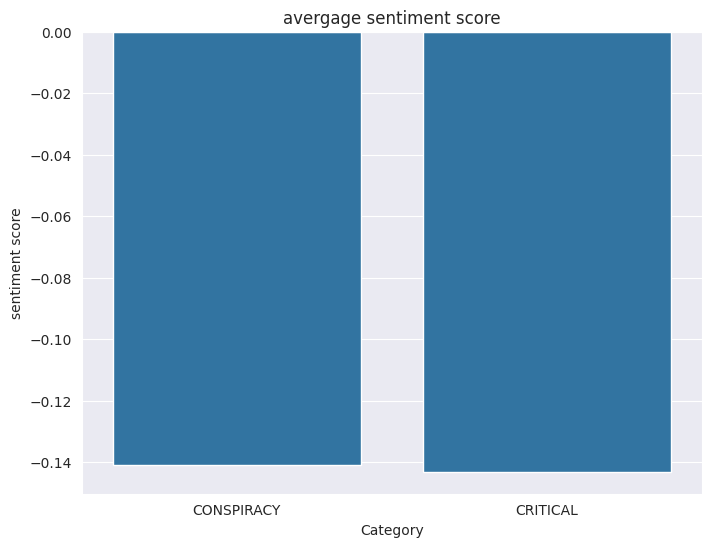

In [13]:
def analyze_sentiment(comment):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(comment)
    return sentiment

CONSPIRACY_sentiment_scores = []
CRITICAL_sentiment_scores = []


for comment in data:  
    sentiment = analyze_sentiment(comment["text"])["compound"] 
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_sentiment_scores.append(sentiment)
    else:
        CRITICAL_sentiment_scores.append(sentiment)

categories = ['CONSPIRACY', 'CRITICAL']
sentiment_scores = [np.mean(CONSPIRACY_sentiment_scores), np.mean(CRITICAL_sentiment_scores)]

df = pd.DataFrame({
    'Category': categories,
    'Sentiment Score': sentiment_scores
})

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Sentiment Score', data=df)
plt.xlabel('Category')
plt.ylabel('sentiment score')
plt.title('avergage sentiment score')
# save fig
plt.savefig("../reports/figures/01/sentiment_score.png")
plt.show()



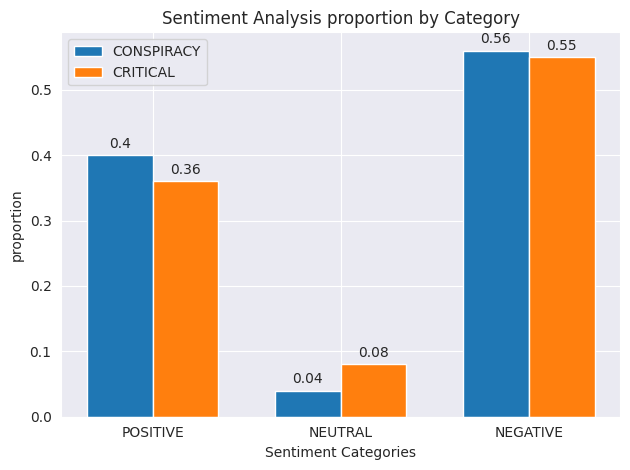

In [15]:


def categorize_sentiments(sentiment_scores):
    # Initialize a dictionary to hold the count of each sentiment category
    sentiment_counts = {'pos': 0, 'neutral': 0, 'neg': 0}

    # Iterate through each score in the input list
    for score in sentiment_scores:
        # Categorize the sentiment based on the compound score
        if score >= 0.05:
            sentiment_counts['pos'] += 1
        elif score <= -0.05:
            sentiment_counts['neg'] += 1
        else:
            sentiment_counts['neutral'] += 1

    return sentiment_counts


CONSPIRACY_sentiment_scores_categories = categorize_sentiments(CONSPIRACY_sentiment_scores)
CRITICAL_sentiment_scores_categories = categorize_sentiments(CRITICAL_sentiment_scores)

# Data setup
categories = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
conspiracy_counts = [round(CONSPIRACY_sentiment_scores_categories['pos']/CONSPIRACY_counter,2),round(CONSPIRACY_sentiment_scores_categories['neutral']/CONSPIRACY_counter,2), round(CONSPIRACY_sentiment_scores_categories['neg']/CONSPIRACY_counter,2)]
critical_counts = [round(CRITICAL_sentiment_scores_categories['pos']/CRITICAL_counter,2), round(CRITICAL_sentiment_scores_categories['neutral']/CRITICAL_counter,2), round(CRITICAL_sentiment_scores_categories['neg']/CRITICAL_counter,2)]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, conspiracy_counts, width, label='CONSPIRACY')
rects2 = ax.bar(x + width/2, critical_counts, width, label='CRITICAL')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Sentiment Categories')
ax.set_ylabel('proportion')
ax.set_title('Sentiment Analysis proportion by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to add labels on the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to label the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
# save fig
plt.savefig("../reports/figures/01/sentiment_analysis_proportion.png")
plt.show()

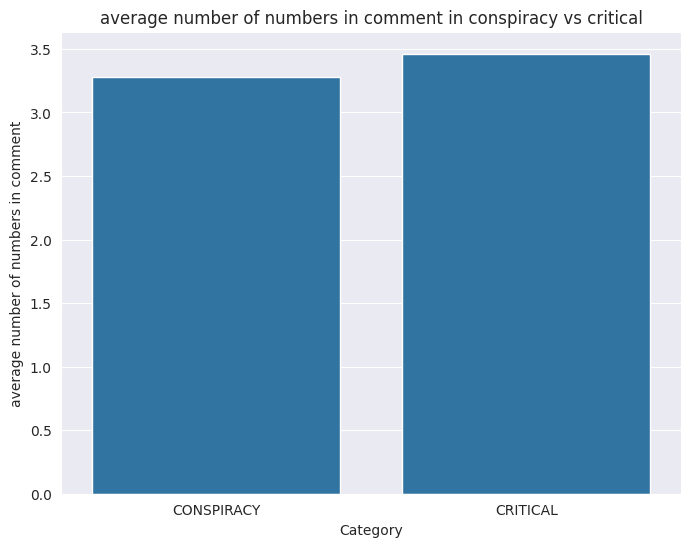

In [18]:
def extract_numbers_with_decimals(text):   
    numbers = re.findall(r'\d+\.\d+|\d+', text)
    numbers = [float(num) if '.' in num else int(num) for num in numbers]
    return numbers

CONSPIRACY_decimals = []
CRITICAL_decimals = []

decimals = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_decimals.append(len(extract_numbers_with_decimals(comment["text"])))
    else:
        CRITICAL_decimals.append(len(extract_numbers_with_decimals(comment["text"])))


categories = ['CONSPIRACY', 'CRITICAL']

avereage_bad_word_proportion_per_comment_number= [np.mean(CONSPIRACY_decimals), np.mean(CRITICAL_decimals)]

df = pd.DataFrame({
    'Category': categories,
    'average number of numbers in comment': avereage_bad_word_proportion_per_comment_number
})

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='average number of numbers in comment', data=df)
plt.xlabel('Category')
plt.ylabel('average number of numbers in comment')
plt.title('average number of numbers in comment in conspiracy vs critical')
# save fig
plt.savefig("../reports/figures/01/average_number_of_numbers.png")
plt.show()
    



In [21]:
from collections import Counter

CONSPIRACY_decimals = []
CRITICAL_decimals = []

decimals = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_decimals += (extract_numbers_with_decimals(comment["text"]))
    else:
        CRITICAL_decimals += (extract_numbers_with_decimals(comment["text"]))

CONSPIRACY_counter = Counter(CONSPIRACY_decimals)
CONSPIRACY_number_counts = dict(CONSPIRACY_counter)
CONSPIRACY_number_counts = {k: v for k, v in sorted(CONSPIRACY_number_counts.items(), key=lambda item: item[1])}

CRITICAL_counter = Counter(CRITICAL_decimals)
CRITICAL_number_counts = dict(CRITICAL_counter)
CRITICAL_number_counts = {k: v for k, v in sorted(CRITICAL_number_counts.items(), key=lambda item: item[1])}

# dictionary: key (number) value: number of its occurence
# dict is sorted by the number of occurences
print(CONSPIRACY_number_counts)
print(CRITICAL_number_counts)

{1.7: 1, 40525569: 1, 9779559: 1, 28606: 1, 1670304968950022144: 1, 360089: 1, 136641: 1, 1503452541450870787: 1, 1957: 1, 9368: 1, 17330: 1, 8299317: 1, 1408109674436567049: 1, 682: 1, 207: 1, 1525: 1, 1562: 1, 134922: 1, 18328: 1, 54817: 1, 38652: 1, 54001: 1, 0.1: 1, 0.3: 1, 1.3: 1, 115: 1, 206: 1, 3.4: 1, 3.6: 1, 3.8: 1, 4.4: 1, 4.6: 1, 6.2: 1, 12143935: 1, 9416347: 1, 99999: 1, 1376894411028770816: 1, 18953: 1, 25.1: 1, 11017119: 1, 545: 1, 2100: 1, 1116502: 1, 465: 1, 565018: 1, 1919: 1, 517: 1, 11635264333: 1, 121: 1, 49: 1, 569: 1, 356: 1, 253: 1, 57: 1, 257: 1, 604: 1, 1995: 1, 374: 1, 376: 1, 602: 1, 541: 1, 618: 1, 620: 1, 621: 1, 623: 1, 644: 1, 645: 1, 701: 1, 702: 1, 718: 1, 719: 1, 717: 1, 677: 1, 596: 1, 628: 1, 1206574413523476480: 1, 77962970: 1, 80132944: 1, 1961: 1, 8630821: 1, 18141: 1, 1069000436756172800: 1, 11005783: 1, 48266: 1, 700: 1, 777: 1, 14254: 1, 386: 1, 212: 1, 10536697: 1, 32000: 1, 1572855465272279042: 1, 1891: 1, 32467: 1, 77: 1, 48704213: 1, 104113

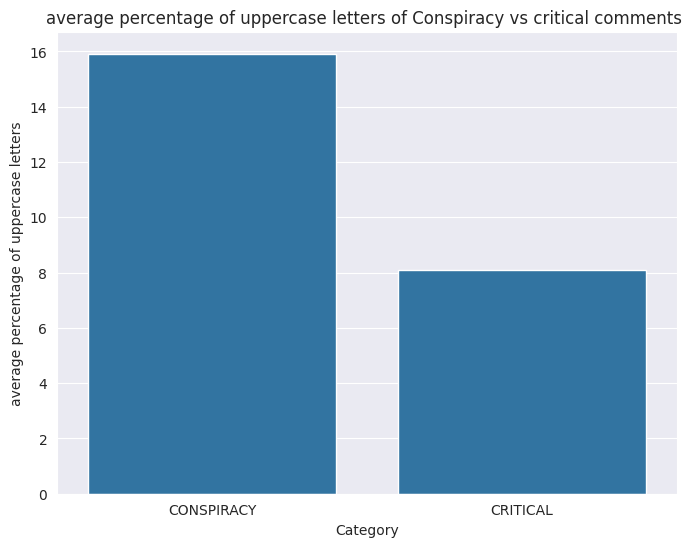

In [19]:
def calculate_uppercase_percentage(text):
    # Initialize counters for uppercase letters and total letters
    uppercase_count = 0
    total_letters = 0
    
    # Loop through each character in the text
    for char in text:
        if char.isalpha():  # Check if the character is a letter
            total_letters += 1
            if char.isupper():  # Check if the letter is uppercase
                uppercase_count += 1
    
    # Calculate the percentage of uppercase letters
    if total_letters == 0:
        return 0
    uppercase_percentage = (uppercase_count / total_letters) * 100
    
    return uppercase_percentage


CONSPIRACY_uppercase_letters = []
CRITICAL_uppercase_letters = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_uppercase_letters.append(calculate_uppercase_percentage(comment["text"]))
    else:
        CRITICAL_uppercase_letters.append(calculate_uppercase_percentage(comment["text"]))

categories = ['CONSPIRACY', 'CRITICAL']

avereage_bad_word_proportion_per_comment_number= [np.mean(CONSPIRACY_uppercase_letters), np.mean(CRITICAL_uppercase_letters)]
df = pd.DataFrame({
    'Category': categories,
    'average percentage of uppercase letters': avereage_bad_word_proportion_per_comment_number
})
# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='average percentage of uppercase letters', data=df)
plt.xlabel('Category')
plt.ylabel('average percentage of uppercase letters')
plt.title('average percentage of uppercase letters of Conspiracy vs critical comments ')
# save fig
plt.savefig("../reports/figures/01/average_uppercase_letters.png")
plt.show()

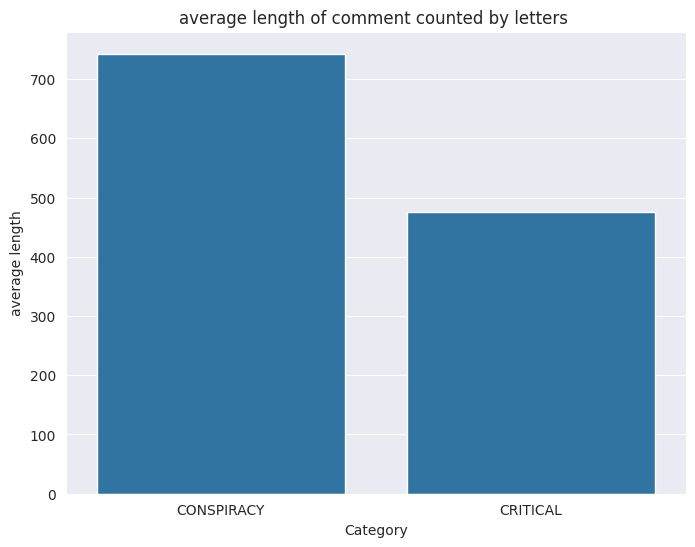

In [20]:
CONSPIRACY_length = []
CRITICAL_length = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_length.append(len(comment["text"]))
    else:
        CRITICAL_length.append(len(comment["text"]))

categories = ['CONSPIRACY', 'CRITICAL']

avereage_bad_word_proportion_per_comment_number= [np.mean(CONSPIRACY_length), np.mean(CRITICAL_length)]
df = pd.DataFrame({
    'Category': categories,
    'average length': avereage_bad_word_proportion_per_comment_number
})
# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='average length', data=df)
plt.xlabel('Category')
plt.ylabel('average length')
plt.title('average length of comment counted by letters ')
# save fig
plt.savefig("../reports/figures/01/average_length.png")
plt.show()